Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети. 

Подсказка: Попробуйте менять размер окна и шаг.

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R '/content/texts' # Проверка наличия папки texts. Если есть, удаляем ее.

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
!unzip -q '/content/drive/MyDrive/Базы/Тексты писателей.zip' -d '/content/texts' #Указываем путь к базе Google Drive, создаем папку texts  и извлекаем туда базу

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов
nClasses

6

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/Тексты писателей/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/Тексты писателей/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/Тексты писателей/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
print(len(trainText))     # количество элементов в trainText
print(len(trainText[0]))  # количество символов в первом источнике(?) в trainText

6
1049517


In [ ]:
sample_text = ['один два три четыре пять два Три три четыре четыре четыре пять пять пять пять шесть семь восемь']
maxWordsCount = 50
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(sample_text)     # передаем тексты в обработку методу, который соберет словать частотности


# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )

In [ ]:
print(len(sample_text[0].split()))

18


In [ ]:
tokenizer.word_index

{'unknown': 1,
 'восемь': 9,
 'два': 5,
 'один': 6,
 'пять': 2,
 'семь': 8,
 'три': 4,
 'четыре': 3,
 'шесть': 7}

In [ ]:
k = tokenizer.texts_to_sequences(sample_text)
print(k)
print(len(k[0]))  

[[6, 5, 4, 3, 2, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 7, 8, 9]]
18


In [ ]:
xTrain = []
k2 = k[0]
while len(k2) >= 3:
  xTrain.append(k2[:3])
  k2 = k2[3:]
xTrain

[[6, 5, 4], [3, 2, 5], [4, 4, 3], [3, 3, 2], [2, 2, 2], [7, 8, 9]]

In [ ]:
tokenizer.sequences_to_matrix(xTrain)

array([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # Передаём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #  Извлекаем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 3.76c


In [ ]:
print(items[:120])   # вывод 120 самых часто встречающихся слов
print("Размер словаря", len(items))   # длина словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь', 77), ('

In [ ]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) # тестирование словаря частотности

Уточните слово: как
Интересующее слово имеет индекс:  11


In [ ]:
# преобразование текста в последовательность индексов согласно частотному словарю (т.е. в индексы)
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

print("Взглянем на фрагмент обучающего текста: ")
print("В виде оригинального текста: ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста: 
В виде оригинального текста:  Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
print("Статистика по обучающим текстам: ")

symbolsTrainText = 0 # объявляем переменную для подсчета симвоволов в обучающих текстах
wordsTrainText = 0 # объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses):    # проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")   
  symbolsTrainText += len(trainText[i])       # считаем символы
  wordsTrainText += len(trainWordIndexes[i])  # считаем слова

print('_ _ _ _')
print('В сумме ', symbolsTrainText, "символов, ", wordsTrainText, "слов \n")
print()
print("Статистика по текстовым текстам:")

symbolsTestText = 0 # Объявляем переменную для для подсчета симвоволов в тестовых текстах
wordTestText = 0    # Объявляем переменную для для подсчета слов в тестовых текстах

for i in range(nClasses):
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  
  symbolsTestText += len(testText[i]) 
  wordTestText += len(testWordIndexes[i])
print('_ _ _ _')
print('В сумме ', symbolsTrainText, "символов, ", wordsTrainText, "слов")

Статистика по обучающим текстам: 
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
_ _ _ _
В сумме  11553605 символов,  1769573 слов 


Статистика по текстовым текстам:
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
_ _ _ _
В сумме  11553605 символов,  1769573 слов


Обучающая и тестовая выборки

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # отделяем векторы длины xLen
    index += step # смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

ПОДГОТОВКА ДАННЫХ

In [ ]:
# Задаем базовые парметры
xLen = 7000 # Длина отрезка текста, по которой анализируем, в словарях
step = 700 # Шаг разбития исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(2472, 7000)
(2472, 6)
(907, 7000)
(907, 6)
Время обработки: 4.08c


In [ ]:
print(xTrain[0])

[ 4725     7  2449 ...   210   384 15576]


In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразуем полученные выборки из последовательности индексов в матрицы нулей и цифр по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())   # Подаем xTrain в виде списка, чтобы метод успешно работал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())     # Подаем xTest в виде списка, чтобы метод успешно работал

print(xTrain01.shape)   # Размер обучающей выборки
print(xTrain01[0][0:100])  # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(2472, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1.]
Время обработки: 9.14c


In [ ]:
for i in range(100):
  print(int(i in xTrain[0]), end=' ')

0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 

РАСПОЗНАВАНИЕ ПРОВЕРОЧНОЙ ВЫБОРКИ

1.   Новый пункт
2.   Новый пункт



In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount


In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step)  #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
I = np.array(xTest6Classes01)
np.save('xTestPredictBow', I)
np.save('xTestPredictEmbedding', x2)

BagofWords + softmax

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))

Epoch 1/10
20/20 [==============================] - 0s 25ms/step - loss: 2.6795e-05 - accuracy: 1.0000 - val_loss: 0.1573 - val_accuracy: 0.9713
Epoch 2/10
20/20 [==============================] - 0s 17ms/step - loss: 2.6200e-05 - accuracy: 1.0000 - val_loss: 0.1566 - val_accuracy: 0.9724
Epoch 3/10
20/20 [==============================] - 0s 17ms/step - loss: 3.2451e-05 - accuracy: 1.0000 - val_loss: 0.1557 - val_accuracy: 0.9713
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 2.6145e-05 - accuracy: 1.0000 - val_loss: 0.1557 - val_accuracy: 0.9713
Epoch 5/10
20/20 [==============================] - 0s 17ms/step - loss: 2.6166e-05 - accuracy: 1.0000 - val_loss: 0.1564 - val_accuracy: 0.9713
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 2.2280e-05 - accuracy: 1.0000 - val_loss: 0.1561 - val_accuracy: 0.9713
Epoch 7/10
20/20 [==============================] - 0s 17ms/step - loss: 2.2398e-05 - accuracy: 1.0000 - val_loss: 0.1560 - val_ac

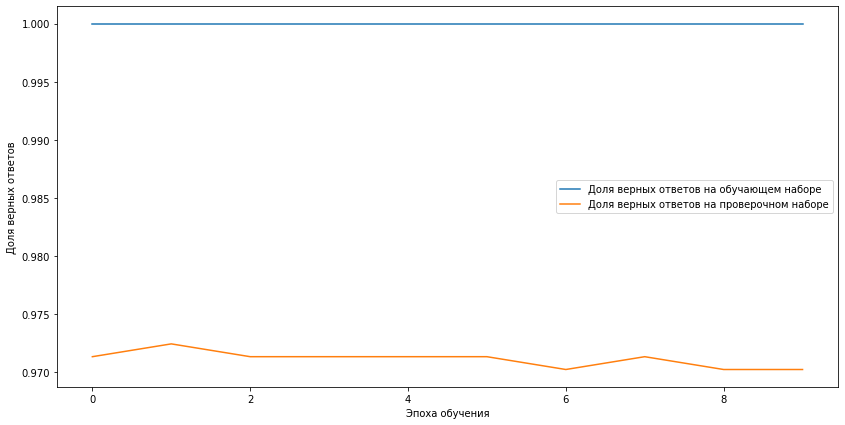

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               4000200   
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________


In [ ]:
model01.save_weights('model.h5')


In [ ]:
model01.load_weights('model.h5')

In [ ]:
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 100% сеть отнесла к классу СтругацкиеЭто ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       90% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%



EMBEDDING + DENSE

In [ ]:
# Model with Embedding layer
model02 = Sequential()
model02.add(Embedding(maxWordsCount, 10, input_length=xLen))
model02.add(SpatialDropout1D(0.2))
model02.add(Flatten())
model02.add(BatchNormalization())
model02.add(Dense(200, activation="relu"))
model02.add(Dropout(0.2))
model02.add(BatchNormalization())
model02.add(Dense(6, activation='softmax'))

model02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model02.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 10)          200000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 5000, 10)         0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 50000)            200000    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 200)               10000200  
                                                                 
 dropout_2 (Dropout)         (None, 200)              

In [ ]:
history2 = model02.fit(xTrain, yTrain, epochs=10, batch_size=128, validation_data=(xTest, yTest))

Epoch 1/10
272/272 [==============================] - 59s 212ms/step - loss: 0.3186 - accuracy: 0.9041 - val_loss: 1.5068 - val_accuracy: 0.4342
Epoch 2/10
272/272 [==============================] - 58s 212ms/step - loss: 0.0092 - accuracy: 0.9980 - val_loss: 0.8191 - val_accuracy: 0.7109
Epoch 3/10
272/272 [==============================] - 57s 209ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.5358 - val_accuracy: 0.8282
Epoch 4/10
272/272 [==============================] - 57s 210ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.7307 - val_accuracy: 0.7613
Epoch 5/10
272/272 [==============================] - 56s 207ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.6807 - val_accuracy: 0.7709
Epoch 6/10
272/272 [==============================] - 57s 209ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.5736 - val_accuracy: 0.8185
Epoch 7/10
272/272 [==============================] - 57s 210ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.5936 - val_ac

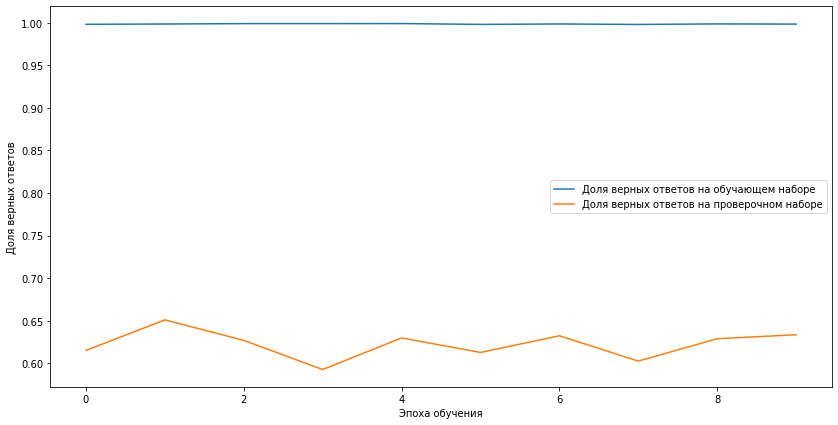

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model02.save_weights('model.h5')
model02.load_weights('model.h5')

In [ ]:
# Проверка результатов работы Embedding сети.
_,xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # Преобразование тестовой выборки
pred = recognizeMultiClass(model02, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding + Dense

Класс: О. Генри   61% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 52% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   70% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     68% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       78% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  40% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 63%



In [ ]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(maxWordsCount, 200, input_length=xLen))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dropout(0.2))
model03.add(BatchNormalization())
model03.add(Dense(6, activation='sigmoid'))

model03.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model03.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         4000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 200)        0         
 lDropout1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 200000)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 200000)           800000    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 200)               40000200  
                                                                 
 dropout_1 (Dropout)         (None, 200)              

In [ ]:
#Обучаем сеть c Embadding layers на xTrain
history03 = model03.fit(xTrain, yTrain, epochs=10, batch_size=128, validation_data=(xTest, yTest))

Epoch 1/10
138/138 [==============================] - 15s 100ms/step - loss: 0.6169 - accuracy: 0.8291 - val_loss: 1.6277 - val_accuracy: 0.3646
Epoch 2/10
138/138 [==============================] - 14s 100ms/step - loss: 0.0099 - accuracy: 0.9999 - val_loss: 1.5296 - val_accuracy: 0.3504
Epoch 3/10
138/138 [==============================] - 14s 99ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.1984 - val_accuracy: 0.5265
Epoch 4/10
138/138 [==============================] - 14s 101ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.9433 - val_accuracy: 0.6720
Epoch 5/10
138/138 [==============================] - 13s 98ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.8519 - val_accuracy: 0.7098
Epoch 6/10
138/138 [==============================] - 15s 106ms/step - loss: 7.4807e-04 - accuracy: 1.0000 - val_loss: 0.8488 - val_accuracy: 0.7175
Epoch 7/10
138/138 [==============================] - 15s 108ms/step - loss: 6.0234e-04 - accuracy: 1.0000 - val_loss: 0.8382 - 

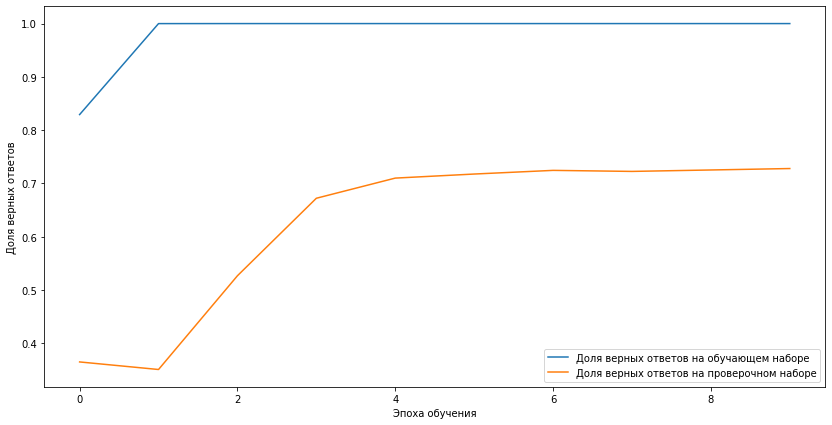

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history03.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history03.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Проверка результатов работы Embedding сети.
_,xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # Преобразование тестовой выборки
pred = recognizeMultiClass(model03, xTest6Classes, "Embedding на xTrain")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding на xTrain

Класс: О. Генри   85% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 68% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   61% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     69% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       83% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  68% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 72%

